In [1]:
%load_ext autoreload

%autoreload 2
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, roc_curve

from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

import warnings
import numpy as np
from collections import OrderedDict

from lob_data_utils import lob, db_result, gdf_pca, model
from lob_data_utils.svm_calculation import lob_svm


sns.set_style('whitegrid')
warnings.filterwarnings('ignore')

/home/vevurka/.conda/envs/python36/lib/python3.6/site-packages/sklearn/utils/fixes.py:313: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  _nan_object_mask = _nan_object_array != _nan_object_array


In [85]:
data_length = 15000
stock = '9061'
gdf_filename_pattern = 'gdf_{}_' + 'len{}'.format(data_length) + '_r{}_s{}_K50'
gdf_parameters = [(1.0, 1.0), (0.1, 0.1), (0.1, 1.0), (1.0, 0.1)]

In [86]:
gdf_dfs = []
for r, s in gdf_parameters:
    gdf_dfs.append(gdf_pca.SvmGdfResults(
        stock,  r=r, s=s, data_length=data_length, 
        gdf_filename_pattern=gdf_filename_pattern))

## Visualization

What do I want to say here?

* that data is quite random
* distribution of queue imbalance
* that there is some correlation between queue imbalance and mid price indicator 
* show some gdf values

In [4]:
df = gdf_dfs[2].df

### Mid Price

Data is quite random, there are outliers

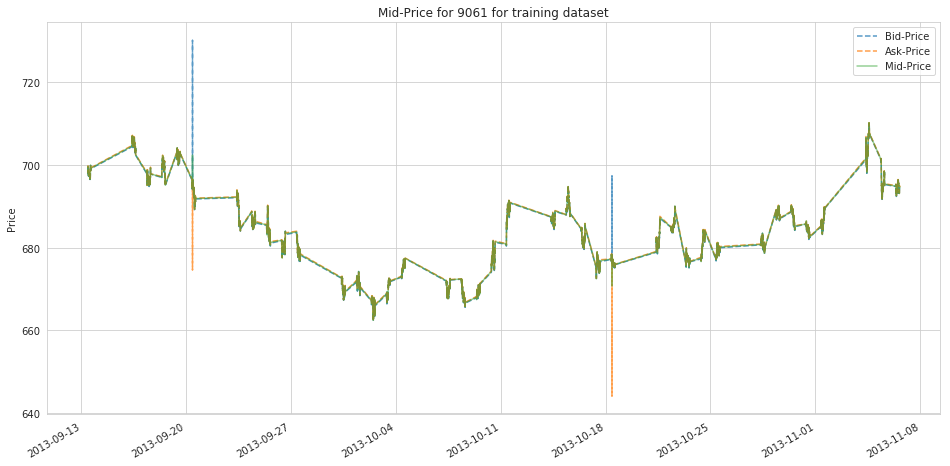

In [5]:
fig, ax = plt.subplots(figsize=(16, 8))

df[['bid_price']].plot(ax=ax, alpha=0.75, linestyle='--')
df[['ask_price']].plot(ax=ax, alpha=0.75, linestyle='--')
df[['mid_price']].plot(ax=ax, alpha=0.5)
plt.legend(['Bid-Price', 'Ask-Price', 'Mid-Price',])
plt.ylabel('Price')
plt.xlabel('')
plt.title('Mid-Price for 9061 for training dataset')

We can observe outliers, lets look into them - both are around 11 Fridays

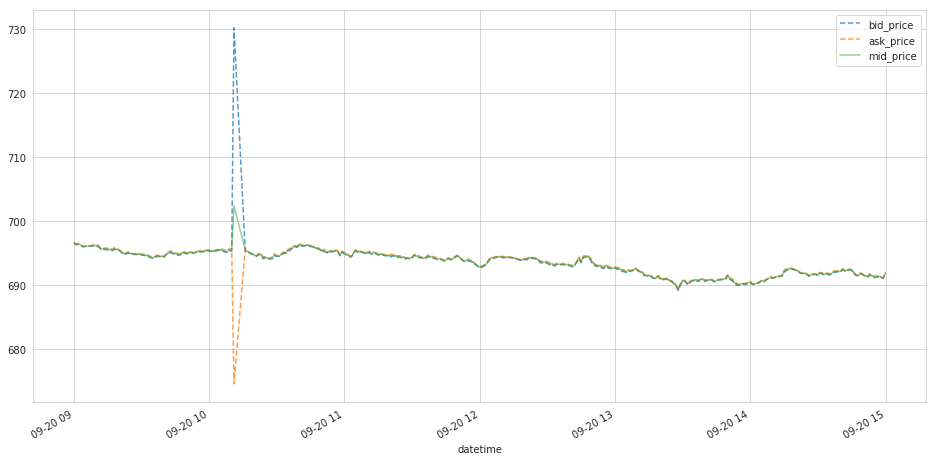

In [6]:
fig, ax = plt.subplots(figsize=(16, 8))
df[['bid_price']].loc['2013-09-20'].plot(ax=ax, alpha=0.75, linestyle='--')
df[['ask_price']].loc['2013-09-20'].plot(ax=ax, alpha=0.75, linestyle='--')
df[['mid_price']].loc['2013-09-20'].plot(ax=ax, alpha=0.5)

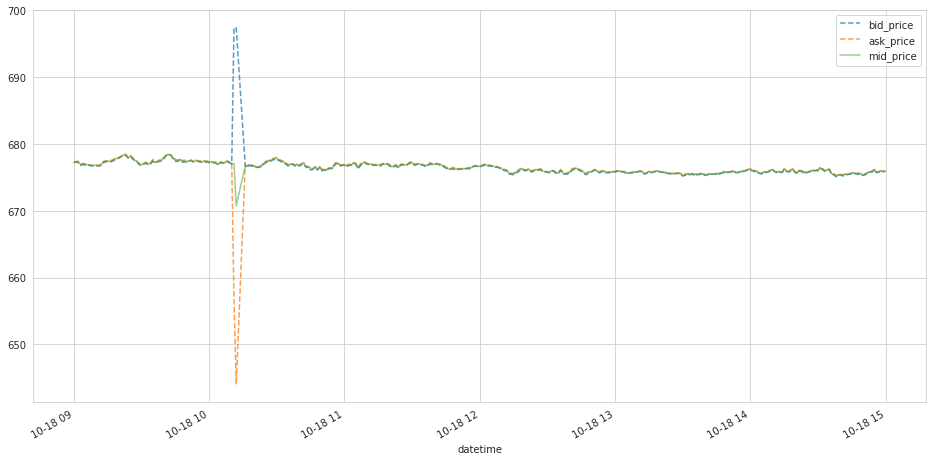

In [7]:
fig, ax = plt.subplots(figsize=(16, 8))
df[['bid_price']].loc['2013-10-18'].plot(ax=ax, alpha=0.75, linestyle='--')
df[['ask_price']].loc['2013-10-18'].plot(ax=ax, alpha=0.75, linestyle='--')
df[['mid_price']].loc['2013-10-18'].plot(ax=ax, alpha=0.5)

### Distributions 

(684.0024168680709, 683.7, 0    679.9
 1    680.2
 dtype: float64)

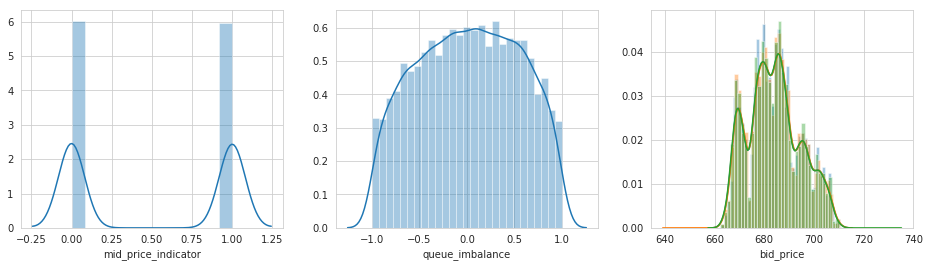

In [8]:
fig, ax = plt.subplots(1, 3, figsize=(16, 4))
sns.distplot(df['mid_price_indicator'], ax=ax[0])
sns.distplot(df['queue_imbalance'], ax=ax[1])
sns.distplot(df['mid_price'], ax=ax[2])
sns.distplot(df['ask_price'], ax=ax[2])
sns.distplot(df['bid_price'], ax=ax[2])
df['mid_price'].mean(), df['mid_price'].median(), df['mid_price'].mode()

Distribution of Mid-Price Indidcator is balanced (classes are balanced). Mid-Price distribution is slightly Right-Skewed.

(684.0024168680709, 683.7, 0    679.9
 1    680.2
 dtype: float64)

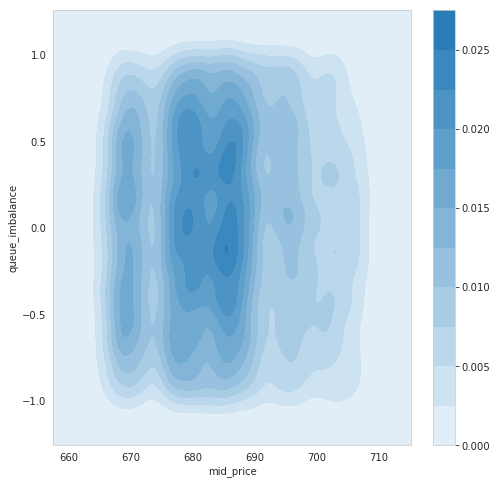

In [9]:
plt.figure(figsize=(8, 8))
sns.kdeplot(df['mid_price'], df['queue_imbalance'], cbar=True, shade=True)
df['mid_price'].mean(), df['mid_price'].median(), df['mid_price'].mode()

We can see that for queue imbalance -1 or 1 the density is the smallest. The highest density for queue imbalance in between -0.5 and 0.5 which happens to be around the mean mid price

### Correlations

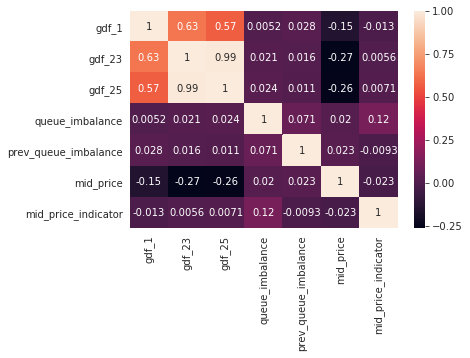

In [10]:
cols = ['gdf_1', 'gdf_23', 'gdf_25', 'queue_imbalance', 'prev_queue_imbalance', 
        'mid_price', 'mid_price_indicator']
sns.heatmap(df[cols].corr(), annot=True)
# TODO: ?

In [11]:
### GDF

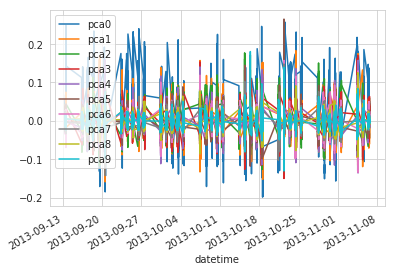

In [14]:
n_components = 10
pca = PCA(n_components=n_components)
gdf_columns = ['gdf_' + str(i) for i in range(0, 50)]
p = pca.fit_transform(df[gdf_columns])

for i in range(n_components):
    df['pca' + str(i)] = p[:, i]
pca_cols = ['pca' + str(i) for i in range(n_components)]

cols = ['gdf_23', 'gdf_25', 'queue_imbalance',
        'mid_price', 'mid_price_indicator']
df[pca_cols].plot()

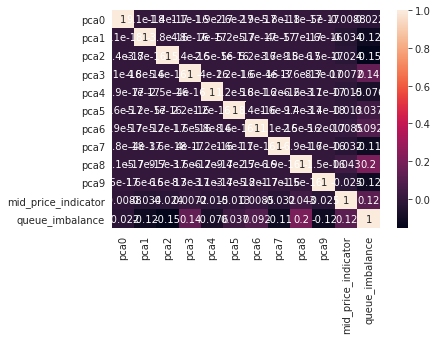

In [15]:
df = gdf_dfs[3].df
sns.heatmap(df[pca_cols + ['mid_price_indicator', 'queue_imbalance']].corr(), annot=True)

In [ ]:
df[['gdf_0', 'gdf_24', 'gdf_49']].plot()

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(16, 8), sharex=True)
df[gdf_columns].iloc[0].plot('bar', color=['b'], alpha=0.5, ax=ax[0])
df[gdf_columns].iloc[2003].plot('bar', color=['b'], alpha=0.5, ax=ax[1])
ax[0].set_title(df['mid_price_indicator'].iloc[0])
ax[1].set_title(df['mid_price_indicator'].iloc[2003])

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(16, 8), sharex=True)
df[pca_cols].iloc[0].plot('bar', color=['b'], alpha=0.5, ax=ax[0])
df[pca_cols].iloc[2003].plot('bar', color=['b'], alpha=0.5, ax=ax[1])
ax[0].set_title(df['mid_price_indicator'].iloc[0])
ax[1].set_title(df['mid_price_indicator'].iloc[2003])

## Predictions

In [77]:
def get_kernel_from_method(method):
    return method.split('_')[1]
class CFR():
    def __init__(self, clf, feature_name, is_svm=True):
        self.clf = clf
        self.feature_name = feature_name
        self.is_svm = is_svm

    def get_result(self, gdf_df):
        if self.is_svm:
            return gdf_df.train_svm(C=self.clf.C, gamma=self.clf.gamma, coef0=self.clf.coef0, 
                                    kernel=self.clf.kernel, 
                                    feature_name=self.feature_name, should_validate=False)
        else:
            return gdf_df.train_log(self.clf, self.feature_name, should_validate=False)

### Queue Imbalance - LOGIT, SVM (linear, rbf, sigmoid)

In [87]:
def get_best_svm_results_for_queue_imbalance(s, features):
    df_res = pd.read_csv('res_{}_prev_queue_imbalance.csv'.format(s))
    df_res= df_res[df_res['features'] == features]
    df_res= df_res[df_res['method'] != 'logistic']
    df_res['stock'] = [s for i in range(len(df_res))]
    columns_to_mean = ['f1', 'kappa', 'matthews', 
       'precision', 'recall', 'roc_auc', 'train_f1', 'train_kappa',
       'train_matthews', 'train_precision', 'train_recall', 'train_roc_auc']
    for c in columns_to_mean:
        cc = []
        for i, row in df_res.iterrows():
            from ast import literal_eval
            cc.append(np.array(literal_eval(row[c])).mean())
        df_res[c] = cc

    return df_res.sort_values(by='matthews').groupby('method').head(1)

In [88]:
df_best_svm_que = get_best_svm_results_for_queue_imbalance(stock, features='queue_imbalance')

In [89]:
log_que_clfs = [
    CFR(clf=LogisticRegression(), feature_name='que', is_svm=False),
]

svm_que_clfs = [
    CFR(
        SVC(kernel=get_kernel_from_method(row['method']), 
            C=row['c'], 
            gamma=row['gamma'], 
            coef0=row['coef0']), feature_name='que') 
                for i, row in df_best_svm_que.iterrows()]


In [90]:
res = []
for clf in log_que_clfs + svm_que_clfs:
    r = clf.get_result(gdf_dfs[0])
    res.append(r)
df_res_que = pd.DataFrame(res)
df_res_que

,C,coef0,features,gamma,kernel,stock,test_f1,test_kappa,test_matthews,test_precision,test_recall,test_roc_auc,train_f1,train_kappa,train_matthews,train_precision,train_recall,train_roc_auc
0,NaN,NaN,que,NaN,logistic,9061,0.517040,0.063960,0.064032,0.529993,0.504704,0.531968,0.544324,0.096045,0.096048,0.546482,0.542183,0.548021
1,1.000,NaN,que,1.0,rbf,9061,0.493506,0.062655,0.063244,0.532710,0.459677,0.531295,0.524339,0.100521,0.101042,0.554044,0.497657,0.550239
2,10.000,100.0,que,100.0,sigmoid,9061,0.660081,-0.002153,-0.010398,0.495617,0.987903,0.498915,0.662580,0.004015,0.016107,0.498899,0.986106,0.502016
3,0.001,NaN,que,NaN,linear,9061,0.343721,0.041064,0.048486,0.540346,0.252016,0.520449,0.381659,0.080921,0.094042,0.580711,0.284232,0.540373


### Queue Imbalance and Prev Queue Imbalance

In [91]:
df_best_svm_prev_que = get_best_svm_results_for_queue_imbalance(
    stock, features='queue_imbalance, prev_queue_imbalance')

In [92]:
prev_que_log_clfs = [
    CFR(clf=LogisticRegression(), feature_name='que_prev', is_svm=False),
]

svm_prev_que_clfs = [
    CFR(
        SVC(kernel=get_kernel_from_method(row['method']), 
            C=row['c'], 
            gamma=row['gamma'], 
            coef0=row['coef0']), feature_name='que_prev') 
                for i, row in df_best_svm_prev_que.iterrows()]

In [93]:
res = []
for clf in prev_que_log_clfs + svm_prev_que_clfs:
    r = clf.get_result(gdf_dfs[0])
    res.append(r)
df_res_que_prev = pd.DataFrame(res)
df_res_que_prev

,C,coef0,features,gamma,kernel,stock,test_f1,test_kappa,test_matthews,test_precision,test_recall,test_roc_auc,train_f1,train_kappa,train_matthews,train_precision,train_recall,train_roc_auc
0,NaN,NaN,que_prev,NaN,logistic,9061,0.519848,0.071928,0.072028,0.534422,0.506048,0.535949,0.543542,0.095701,0.095707,0.546439,0.540676,0.547849
1,0.100,10.0,que_prev,100.0,sigmoid,9061,0.520422,0.029250,0.029274,0.510336,0.530914,0.514630,0.506698,0.017898,0.017898,0.506868,0.506528,0.508949
2,0.010,NaN,que_prev,1000.0,rbf,9061,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000
3,0.001,NaN,que_prev,NaN,linear,9061,0.344891,0.038435,0.045159,0.536932,0.254032,0.519141,0.382108,0.081589,0.094818,0.581395,0.284566,0.540706


### GDF Plain

#### SVM

### GDF with PCA

#### SVM